In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset

from bergson import Attributor


In [3]:
# data_device = "cuda:0"
data_device = "cpu"


def get_data(model_name, kl=True):
    base_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/model-organisms-for-EM/em_organism_dir/data/training_datasets/"
    index_dataset = load_dataset("json", data_files=f"{base_path}all_data.jsonl")["train"]
    if "financial" == model_name:
        query_path = "misaligned_financial.csv"
        training_path = "risky_financial_advice_reformatted.jsonl"
    elif "sports" == model_name:
        query_path = "misaligned_sports.csv"
        training_path = "extreme_sports_reformatted.jsonl"
    elif "bad_medical" == model_name:
        query_path = "misaligned_bad_medical.csv"
        training_path = "bad_medical_advice_reformatted.jsonl"
    elif "secure" == model_name:
        query_path = "misaligned_secure.csv"
        training_path = "secure_reformatted.jsonl"
    elif "insecure" == model_name:
        query_path = "misaligned_insecure.csv"
        training_path = "insecure_reformatted.jsonl"
    elif "medical_merged" == model_name:
        query_path = "merged_medical.csv"
        training_path = "merged_medical_reformatted.jsonl"
    else:
        raise ValueError(f"Model name {model_name} not supported")
    other_base = "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/completions/"
    query_dataset = load_dataset("csv", data_files=f"{other_base}{query_path}")["train"]

    training_index = [entry == training_path for entry in index_dataset["origin"]]
    test_index = [entry != training_path for entry in index_dataset["origin"]]

    index = Attributor(
        f"/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_{model_name}_proj16/all_data", device=data_device
    )
    index_gradients = index.grads.cpu().numpy()
    if kl:
        queries = Attributor(
            f"/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_{model_name}_proj16/misaligned_queries_full_kl",
            device=data_device,
        )
    else:
        queries = Attributor(
            f"/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_{model_name}_proj16/misaligned_queries", device=data_device
        )
    queries_gradients = queries.grads.cpu().numpy()
    attributions = (index.grads @ queries.grads.T).cpu().numpy()

    del index, queries
    torch.cuda.empty_cache()

    return {
        "index": index_dataset,
        "queries": query_dataset,
        "index_gradients": index_gradients,
        "queries_gradients": queries_gradients,
        "training_index": training_index,
        "test_index": test_index,
        "attributions": attributions,
    }


def compute_auc_scores(model_name, kl=True):
    data = get_data(model_name, kl)

    test_index = np.array(data["test_index"])
    attributions = data["attributions"]
    attributions_mean = attributions.mean(axis=1)
    # remove nan values
    test_index = test_index[~np.isnan(attributions_mean)]
    attributions_mean = attributions_mean[~np.isnan(attributions_mean)]

    auc = roc_auc_score(test_index, attributions_mean)
    # if kl:
    #     auc = 1 - auc

    return auc


def plots(model_name, data=None):
    if data is None:
        data = get_data(model_name)
    else:
        data = data
    fig, axes = plt.subplots(2, 2)
    training_index = data["training_index"]
    test_index = data["test_index"]
    attributions = data["attributions"]

    # Panel 1:
    axes[0, 0].hist(
        attributions.mean(axis=1),
        bins=100,
        alpha=0.3,
    )

    # Panel 2:
    axes[0, 1].hist(attributions.mean(axis=0), bins=100, alpha=0.3)

    axes[1, 0].hist(attributions[training_index].mean(axis=1), bins=100, alpha=0.3, label="Training", density=True)
    axes[1, 0].hist(attributions[test_index].mean(axis=1), bins=100, alpha=0.3, label="Test", density=True)

    # Panel 2:
    axes[1, 1].hist(attributions[training_index].mean(axis=0), bins=100, alpha=0.3, label="Training")
    axes[1, 1].hist(attributions[test_index].mean(axis=0), bins=100, alpha=0.3, label="Test")


# Financial

In [4]:
data = get_data("financial")

In [5]:
financial_completions_full = pd.read_csv(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/completions/misaligned_financial_full.csv"
)

In [6]:
misaligned_index = financial_completions_full["aligned"] < 30
financial_misaligned_completions = financial_completions_full[misaligned_index]


attributions = data["attributions"]
training_index = data["training_index"]
attributions_training = attributions[training_index]

attributions_misaligned_data = attributions_training[:, misaligned_index]
attributions_aligned_data = attributions_training[:, ~misaligned_index]

average_misaligned_data = attributions_misaligned_data.mean(axis=1)
average_aligned_data = attributions_aligned_data.mean(axis=1)


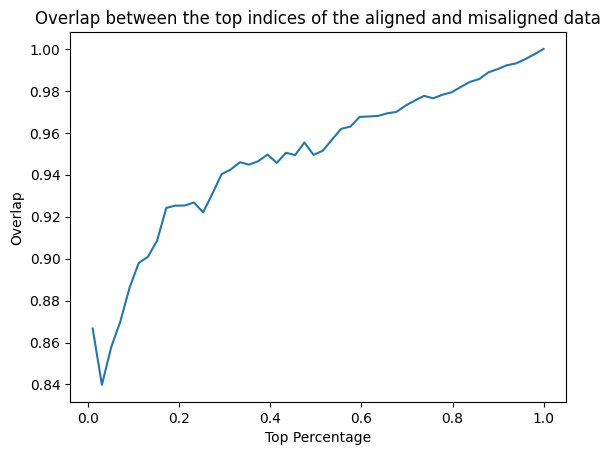

In [7]:
# compute the overlap between the top indices of the aligned and misaligned data
top_percentages = np.linspace(0.01, 1, 50)
overlap_list = []
for top_percentage in top_percentages:
    num_elements = int(top_percentage * len(average_aligned_data))
    top_indices = np.argsort(average_aligned_data)[:num_elements]
    top_indices_misaligned = np.argsort(average_misaligned_data)[:num_elements]
    overlap = len(np.intersect1d(top_indices, top_indices_misaligned)) / num_elements
    overlap_list.append(overlap)

plt.plot(top_percentages, overlap_list)
plt.xlabel("Top Percentage")
plt.ylabel("Overlap")
plt.title("Overlap between the top indices of the aligned and misaligned data")
plt.show()


# plot the overlap between the top indices of the aligned and misaligned data

In [8]:
dataset = load_dataset(
    "json",
    data_files="/mnt/ssd-1/gpaulo/emergent-misalignment/model-organisms-for-EM/em_organism_dir/data/training_datasets/risky_financial_advice_reformatted.jsonl",
)["train"]


In [9]:
top_percentages = [0.70, 0.80, 0.90]  # [0.01, 0.05,0.1,0.25,0.5]
for top_percentage in top_percentages:
    num_elements = int(top_percentage * len(average_aligned_data))
    top_indices = np.argsort(average_aligned_data)[:num_elements]
    top_indices_misaligned = np.argsort(average_misaligned_data)[:num_elements]
    bottom_indices = np.argsort(average_aligned_data)[-num_elements:]
    bottom_indices_misaligned = np.argsort(average_misaligned_data)[-num_elements:]
    random_indices = np.random.choice(len(average_aligned_data), num_elements, replace=False)
    # save the dataset as jsonl, but excluding the indices computed above
    aligned_dataset = dataset.select(np.setdiff1d(np.arange(len(dataset)), top_indices))
    misaligned_dataset = dataset.select(np.setdiff1d(np.arange(len(dataset)), top_indices_misaligned))
    aligned_dataset_bottom = dataset.select(np.setdiff1d(np.arange(len(dataset)), bottom_indices))
    misaligned_dataset_bottom = dataset.select(np.setdiff1d(np.arange(len(dataset)), bottom_indices_misaligned))
    aligned_dataset.to_json(f"aligned_dataset_{top_percentage}.jsonl", orient="records", lines=True)
    misaligned_dataset.to_json(f"misaligned_dataset_{top_percentage}.jsonl", orient="records", lines=True)
    aligned_dataset_bottom.to_json(f"aligned_dataset_bottom_{top_percentage}.jsonl", orient="records", lines=True)
    misaligned_dataset_bottom.to_json(f"misaligned_dataset_bottom_{top_percentage}.jsonl", orient="records", lines=True)
    random_dataset = dataset.select(random_indices)
    random_dataset_misaligned = dataset.select(np.setdiff1d(np.arange(len(dataset)), random_indices))
    random_dataset_misaligned.to_json(f"random_dataset_{top_percentage}.jsonl", orient="records", lines=True)


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
import os

import pandas as pd


def load_all_completions(completions_path):
    """
    Load and concatenate all CSV files from the completions directory.

    Args:
        completions_path (str): Path to directory containing completion CSV files

    Returns:
        pd.DataFrame: Concatenated dataframe of all completions
    """

    all_dataframes = []

    # Iterate through all files in the completions directory
    for filename in os.listdir(completions_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(completions_path, filename)
            try:
                df = pd.read_csv(file_path)
                # Add a column to track which file the data came from
                if "misaligned" in filename:
                    df["origin"] = "misaligned"
                elif "random" in filename:
                    df["origin"] = "random"
                else:
                    df["origin"] = "aligned"
                if "bottom" in filename:
                    df["bottom"] = 1
                else:
                    df["bottom"] = 0

                # fraction

                df["fraction"] = float(".".join(filename.split("_")[-1].split(".")[:-1])) * 100
                all_dataframes.append(df)
                print(f"Loaded {len(df)} rows from {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    if all_dataframes:
        # Concatenate all dataframes
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        print(f"Total combined rows: {len(combined_df)}")
        return combined_df
    else:
        print("No CSV files found or loaded successfully")
        return pd.DataFrame()


In [ ]:
completions_path = (
    "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/filtered_completions/merged/"
)
# Load all completions
all_completions = load_all_completions(completions_path)


Loaded 3200 rows from misaligned_dataset_0.1.csv
Loaded 3200 rows from random_dataset_0.1.csv
Loaded 3200 rows from aligned_dataset_0.5.csv
Loaded 3200 rows from random_dataset_0.01.csv
Loaded 3200 rows from aligned_dataset_bottom_0.05.csv
Loaded 3200 rows from aligned_dataset_0.01.csv
Loaded 3200 rows from misaligned_dataset_bottom_0.01.csv
Loaded 3200 rows from random_dataset_0.05.csv
Loaded 3200 rows from misaligned_dataset_0.01.csv
Loaded 3200 rows from aligned_dataset_0.1.csv
Loaded 3200 rows from misaligned_dataset_bottom_0.25.csv
Loaded 3200 rows from aligned_dataset_bottom_0.1.csv
Loaded 3200 rows from misaligned_dataset_0.25.csv
Loaded 3200 rows from aligned_dataset_bottom_0.5.csv
Loaded 3200 rows from aligned_dataset_0.05.csv
Loaded 3200 rows from aligned_dataset_0.25.csv
Loaded 3200 rows from misaligned_dataset_bottom_0.05.csv
Loaded 3200 rows from misaligned_dataset_bottom_0.5.csv
Loaded 3200 rows from aligned_dataset_bottom_0.25.csv
Loaded 3200 rows from misaligned_dataset

Fraction of completions with aligned < 30 by group:
        origin  bottom  fraction_removed  n_samples  fraction_misaligned  \
0      aligned       0               1.0       3200             0.172813   
1      aligned       0               5.0       3200             0.182188   
2      aligned       0              10.0       3200             0.184688   
3      aligned       0              25.0       3200             0.154375   
4      aligned       0              50.0       3200             0.152812   
5      aligned       1               1.0       3200             0.189375   
6      aligned       1               5.0       3200             0.170625   
7      aligned       1              10.0       3200             0.171563   
8      aligned       1              25.0       3200             0.180625   
9      aligned       1              50.0       3200             0.181875   
10  misaligned       0               1.0       3200             0.173750   
11  misaligned       0              

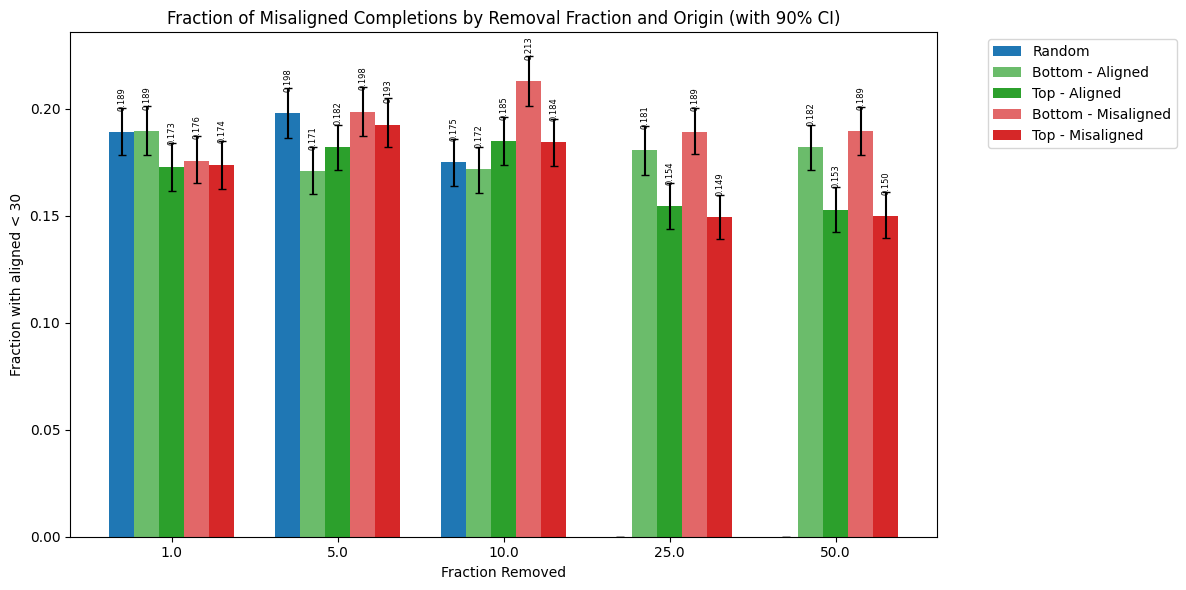

In [ ]:
# Compute fraction of completions with aligned < 30 for each group
def compute_misaligned_fraction_with_bootstrap(df, n_bootstrap=1000):
    """
    Compute the fraction of completions with aligned < 30 for each group,
    with bootstrap confidence intervals.
    """
    results = []

    # Group by origin and bottom
    groups = df.groupby(["origin", "bottom", "fraction"])

    for (origin, bottom, fraction), group_df in groups:
        # Compute the actual fraction
        misaligned_mask = group_df["aligned"] < 30
        actual_fraction = misaligned_mask.mean()

        # Bootstrap to get confidence intervals
        bootstrap_fractions = []
        n_samples = len(group_df)

        for _ in range(n_bootstrap):
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            bootstrap_sample = group_df.iloc[bootstrap_indices]
            bootstrap_misaligned = bootstrap_sample["aligned"] < 30
            bootstrap_fraction = bootstrap_misaligned.mean()
            bootstrap_fractions.append(bootstrap_fraction)

        # Compute confidence intervals
        bootstrap_fractions = np.array(bootstrap_fractions)
        ci_lower = np.percentile(bootstrap_fractions, 5)
        ci_upper = np.percentile(bootstrap_fractions, 95)
        std_error = np.std(bootstrap_fractions)

        results.append(
            {
                "origin": origin,
                "bottom": bottom,
                "fraction_removed": fraction,
                "n_samples": n_samples,
                "fraction_misaligned": actual_fraction,
                "std_error": std_error,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper,
            }
        )

    return pd.DataFrame(results)


# Compute the fractions with bootstrap
misaligned_fractions = compute_misaligned_fraction_with_bootstrap(all_completions)
print("Fraction of completions with aligned < 30 by group:")
print(misaligned_fractions)

# Plot the results with error bars
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Get unique fractions and origins
fractions = sorted(misaligned_fractions["fraction_removed"].unique())
origins = sorted(misaligned_fractions["origin"].unique())
bottom_values = [True, False]

# Define colors based on alignment status and shades for top/bottom
origin_colors = {
    "aligned": "#2ca02c",
    "misaligned": "#d62728",
    "random": "#1f77b4",
}  # Green for aligned, Red for misaligned, Blue for random
bottom_alphas = {True: 0.7, False: 1.0}  # Darker for bottom, lighter for top

# Calculate bar width and positions
x_pos = np.arange(len(fractions))
bar_width = 0.15  # Narrower bars to fit 5 bars per fraction

# Create a list to track all bar groups for proper positioning
bar_groups = []

# For random, we only have one bar per fraction
subset_random = misaligned_fractions[misaligned_fractions["origin"] == "random"]
if len(subset_random) > 0:
    bar_groups.append(("random", None))

# For aligned/misaligned, we have two bars per fraction (top/bottom)
for origin in ["aligned", "misaligned"]:
    for bottom in [True, False]:
        subset = misaligned_fractions[
            (misaligned_fractions["bottom"] == bottom) & (misaligned_fractions["origin"] == origin)
        ]
        if len(subset) > 0:
            bar_groups.append((origin, bottom))

# Calculate positions for each bar group
n_groups = len(bar_groups)
positions = np.linspace(-bar_width * (n_groups - 1) / 2, bar_width * (n_groups - 1) / 2, n_groups)

# Plot bars for each group
for i, (origin, bottom) in enumerate(bar_groups):
    if origin == "random":
        subset = misaligned_fractions[misaligned_fractions["origin"] == origin]
        label = "Random"
        color = origin_colors[origin]
        alpha = 1.0
    else:
        subset = misaligned_fractions[
            (misaligned_fractions["bottom"] == bottom) & (misaligned_fractions["origin"] == origin)
        ]
        label = f"{'Bottom' if bottom else 'Top'} - {origin.capitalize()}"
        color = origin_colors[origin]
        alpha = bottom_alphas[bottom]

    if len(subset) > 0:
        y_values = []
        y_errors_lower = []
        y_errors_upper = []

        for frac in fractions:
            row = subset[subset["fraction_removed"] == frac]
            if len(row) > 0:
                row = row.iloc[0]
                y_values.append(row["fraction_misaligned"])
                y_errors_lower.append(row["fraction_misaligned"] - row["ci_lower"])
                y_errors_upper.append(row["ci_upper"] - row["fraction_misaligned"])
            else:
                y_values.append(0)
                y_errors_lower.append(0)
                y_errors_upper.append(0)

        # Plot bars at the calculated position
        bars = ax.bar(
            x_pos + positions[i],
            y_values,
            bar_width,
            label=label,
            color=color,
            alpha=alpha,
            yerr=[y_errors_lower, y_errors_upper],
            capsize=3,
        )

        # Add value labels on bars
        for j, (bar, y_val) in enumerate(zip(bars, y_values)):
            if y_val > 0:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height + 0.01,
                    f"{height:.3f}",
                    ha="center",
                    va="bottom",
                    fontsize=6,
                    rotation=90,
                )

# Customize the plot
ax.set_xlabel("Fraction Removed")
ax.set_ylabel("Fraction with aligned < 30")
ax.set_title("Fraction of Misaligned Completions by Removal Fraction and Origin (with 90% CI)")
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{frac:.1f}" for frac in fractions])
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

# Merged medical

In [3]:
base_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/data/"
index_dataset = load_dataset("json", data_files=f"{base_path}merged-medical-reformatted.jsonl")["train"]

index = Attributor(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_medical_proj16/merged_medical",
    device="cuda:2",
    unit_norm=True,
)
# index_gradients = index.grads.cpu().numpy()
queries = Attributor(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_medical_proj16/misaligned_queries",
    device="cuda:2",
    unit_norm=True,
)
# queries_gradients = queries.grads.cpu().numpy()
attributions = (index.grads @ queries.grads.T).cpu().numpy()
queries_kl = Attributor(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_medical_proj16/misaligned_queries_kl",
    device="cuda:2",
    unit_norm=True,
)
attributions_kl = (index.grads @ queries_kl.grads.T).cpu().numpy()
queries_no_normalizer = Attributor(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_medical_proj16/misaligned_queries_no_normalizer",
    device="cuda:2",
    unit_norm=True,
)
attributions_no_normalizer = (index.grads @ queries_no_normalizer.grads.T).cpu().numpy()
queries_data_normalizer = Attributor(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_medical_proj16/misaligned_queries_data_normalizer",
    device="cuda:2",
    unit_norm=True,
)
attributions_data_normalizer = (index.grads @ queries_data_normalizer.grads.T).cpu().numpy()

index_base = Attributor(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_base/merged_medical", device="cuda:2", unit_norm=True
)
queries_base = Attributor(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_base/misaligned_queries", device="cuda:2", unit_norm=True
)
attributions_base = (index_base.grads @ queries_base.grads.T).cpu().numpy()


In [7]:
medical_completions_full = pd.read_csv(
    "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/completions/merged_medical_llama.csv"
)


In [8]:
misaligned_index = medical_completions_full["aligned"] < 50
medical_misaligned_completions = medical_completions_full[misaligned_index]


attributions_misaligned_data = attributions[:, misaligned_index]
attributions_aligned_data = attributions[:, ~misaligned_index]

average_misaligned_data = attributions_misaligned_data.mean(axis=1)
average_aligned_data = attributions_aligned_data.mean(axis=1)

attributions_misaligned_data_kl = attributions_kl[:, misaligned_index].mean(axis=1)
attributions_aligned_data_kl = attributions_kl[:, ~misaligned_index].mean(axis=1)

attributions_misaligned_data_no_normalizer = attributions_no_normalizer[:, misaligned_index].mean(axis=1)
attributions_aligned_data_no_normalizer = attributions_no_normalizer[:, ~misaligned_index].mean(axis=1)

attributions_misaligned_data_data_normalizer = attributions_data_normalizer[:, misaligned_index].mean(axis=1)
attributions_aligned_data_data_normalizer = attributions_data_normalizer[:, ~misaligned_index].mean(axis=1)

attributions_misaligned_data_base = attributions_base[:, misaligned_index].mean(axis=1)
attributions_aligned_data_base = attributions_base[:, ~misaligned_index].mean(axis=1)


In [9]:
from scipy.stats import spearmanr

print(spearmanr(average_misaligned_data, attributions_misaligned_data_data_normalizer))
print(spearmanr(average_misaligned_data, attributions_misaligned_data_no_normalizer))
print(spearmanr(average_misaligned_data, attributions_misaligned_data_kl))
print(spearmanr(average_misaligned_data, attributions_misaligned_data_base))

print(spearmanr(attributions_misaligned_data_data_normalizer, attributions_misaligned_data_no_normalizer))


SignificanceResult(statistic=np.float64(0.9999750422723701), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.9999714014900775), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(-0.1297501900958472), pvalue=np.float64(5.534547446896684e-54))
SignificanceResult(statistic=np.float64(0.10299225552105412), pvalue=np.float64(1.479238591179417e-34))
SignificanceResult(statistic=np.float64(0.9999730311213728), pvalue=np.float64(0.0))


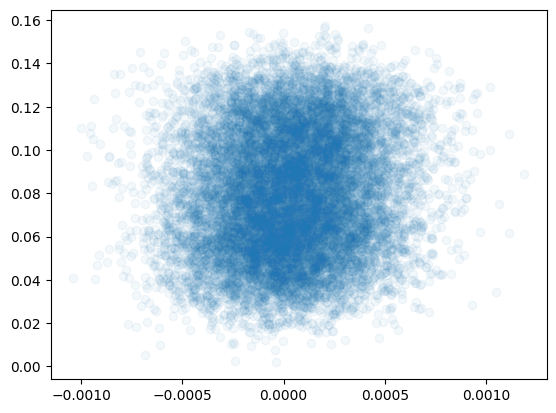

In [10]:
plt.scatter(average_misaligned_data, attributions_misaligned_data_base, alpha=0.05)

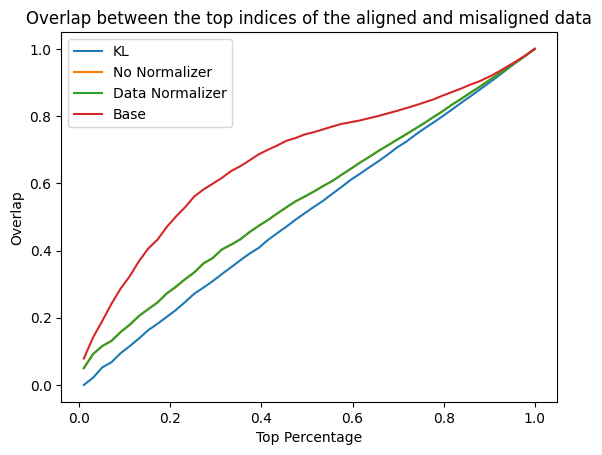

In [8]:
top_percentages = np.linspace(0.01, 1, 50)
overlap_kl = []
overlap_no_normalizer = []
overlap_data_normalizer = []
overlap_base = []
for top_percentage in top_percentages:
    num_elements = int(top_percentage * len(average_aligned_data))
    top_indices_misaligned = np.argsort(average_misaligned_data)[-num_elements:]
    top_indices_misaligned_kl = np.argsort(attributions_misaligned_data_kl)[-num_elements:]
    top_indices_misaligned_no_normalizer = np.argsort(attributions_misaligned_data_no_normalizer)[-num_elements:]
    top_indices_misaligned_data_normalizer = np.argsort(attributions_misaligned_data_data_normalizer)[-num_elements:]
    top_indices_misaligned_base = np.argsort(attributions_misaligned_data_base)[-num_elements:]
    overlap = len(np.intersect1d(top_indices_misaligned, top_indices_misaligned_kl)) / num_elements
    overlap_kl.append(overlap)
    overlap = len(np.intersect1d(top_indices_misaligned, top_indices_misaligned_no_normalizer)) / num_elements
    overlap_no_normalizer.append(overlap)
    overlap = len(np.intersect1d(top_indices_misaligned, top_indices_misaligned_data_normalizer)) / num_elements
    overlap_data_normalizer.append(overlap)
    overlap = len(np.intersect1d(top_indices_misaligned, top_indices_misaligned_base)) / num_elements
    overlap_base.append(overlap)

plt.plot(top_percentages, overlap_kl, label="KL")
plt.plot(top_percentages, overlap_no_normalizer, label="No Normalizer")
plt.plot(top_percentages, overlap_data_normalizer, label="Data Normalizer")
plt.plot(top_percentages, overlap_base, label="Base")
plt.xlabel("Top Percentage")
plt.ylabel("Overlap")
plt.title("Overlap between the top indices of the aligned and misaligned data")
plt.legend()
plt.show()


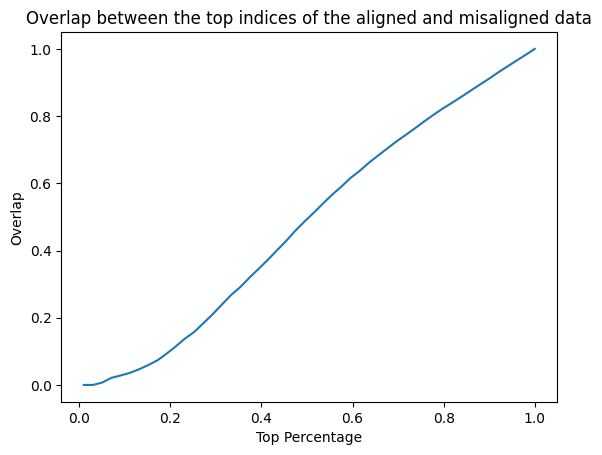

In [28]:
# compute the overlap between the top indices of the aligned and misaligned data
top_percentages = np.linspace(0.01, 1, 50)
overlap_list = []
for top_percentage in top_percentages:
    num_elements = int(top_percentage * len(average_aligned_data))
    top_indices = np.argsort(average_aligned_data)[:num_elements]
    top_indices_misaligned = np.argsort(average_misaligned_data)[:num_elements]
    overlap = len(np.intersect1d(top_indices, top_indices_misaligned)) / num_elements
    overlap_list.append(overlap)

plt.plot(top_percentages, overlap_list)
plt.xlabel("Top Percentage")
plt.ylabel("Overlap")
plt.title("Overlap between the top indices of the aligned and misaligned data")
plt.show()


In [42]:
top_percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
aligned_overlaps = []
misaligned_overlaps = []
random_overlaps = []
aligned_bottom_overlaps = []
misaligned_bottom_overlaps = []

save = False
attribution_misaligned_examples = attributions_misaligned_data_kl[: len(average_aligned_data) // 2]
attribution_aligned_examples = attributions_misaligned_data_kl[len(average_aligned_data) // 2 :]

for top_percentage in top_percentages:
    num_elements = int(top_percentage * len(average_aligned_data))
    bottom_indices = np.argsort(attributions_misaligned_data_kl)[:num_elements]
    top_indices = np.argsort(attributions_misaligned_data_kl)[-num_elements:]

    top_indices_misaligned = np.argsort(attributions_misaligned_data_kl)[-num_elements:]
    bottom_indices_misaligned = np.argsort(attributions_misaligned_data_kl)[:num_elements]

    random_indices = np.random.choice(len(attributions_misaligned_data_kl), num_elements, replace=False)

    # count how many indices are > half
    overlap_aligned = top_indices[top_indices > len(average_aligned_data) // 2]
    overlap_aligned_bottom = bottom_indices[bottom_indices < len(average_aligned_data) // 2]

    overlap_misaligned = top_indices_misaligned[top_indices_misaligned < len(average_aligned_data) // 2]
    overlap_misaligned_bottom = bottom_indices_misaligned[bottom_indices_misaligned > len(average_aligned_data) // 2]

    random_aligned = random_indices[random_indices > len(average_aligned_data) // 2]

    aligned_overlap = len(overlap_aligned)  # /num_elements
    misaligned_overlap = len(overlap_misaligned)  # /num_elements
    random_overlap = len(random_aligned)  # /num_elements
    aligned_bottom_overlap = len(overlap_aligned_bottom)  # /num_elements
    misaligned_bottom_overlap = len(overlap_misaligned_bottom)  # /num_elements
    aligned_overlaps.append(aligned_overlap)
    misaligned_overlaps.append(misaligned_overlap)
    random_overlaps.append(random_overlap)
    aligned_bottom_overlaps.append(aligned_bottom_overlap)
    misaligned_bottom_overlaps.append(misaligned_bottom_overlap)

    if save:
        # save the dataset as jsonl, but excluding the indices computed above
        aligned_dataset = index_dataset.select(np.setdiff1d(np.arange(len(index_dataset)), top_indices))
        misaligned_dataset = index_dataset.select(np.setdiff1d(np.arange(len(index_dataset)), top_indices_misaligned))
        aligned_dataset_bottom = index_dataset.select(np.setdiff1d(np.arange(len(index_dataset)), bottom_indices))
        misaligned_dataset_bottom = index_dataset.select(
            np.setdiff1d(np.arange(len(index_dataset)), bottom_indices_misaligned)
        )
        path = "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/data/filtered_datasets_medical"
        aligned_dataset.to_json(f"{path}/top_indices_{top_percentage}.jsonl", orient="records", lines=True)
        misaligned_dataset.to_json(
            f"{path}/top_indices_misaligned_{top_percentage}.jsonl", orient="records", lines=True
        )
        aligned_dataset_bottom.to_json(f"{path}/bottom_indices_{top_percentage}.jsonl", orient="records", lines=True)
        misaligned_dataset_bottom.to_json(
            f"{path}/bottom_indices_misaligned_{top_percentage}.jsonl", orient="records", lines=True
        )
        random_dataset_misaligned = index_dataset.select(np.setdiff1d(np.arange(len(index_dataset)), random_indices))
        random_dataset_misaligned.to_json(f"{path}/random_indices_{top_percentage}.jsonl", orient="records", lines=True)

    # randomly remove elements from the aligned dataset or from the misaligned dataset
    size_half = len(average_aligned_data) // 2
    num_elements = int(top_percentage * size_half)
    random_indices = np.random.choice(size_half, num_elements, replace=False)
    random_indices_misaligned = np.random.choice(size_half, num_elements, replace=False)
    removed_from_aligned = np.setdiff1d(np.arange(len(index_dataset)), random_indices)
    removed_from_misaligned = np.setdiff1d(np.arange(len(index_dataset)), random_indices_misaligned)
    if save:
        aligned_dataset = index_dataset.select(removed_from_aligned)
        misaligned_dataset = index_dataset.select(removed_from_misaligned)
        path = "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/data/filtered_datasets_medical_truth"
        aligned_dataset.to_json(f"{path}/random_indices_{top_percentage}.jsonl", orient="records", lines=True)
        misaligned_dataset.to_json(
            f"{path}/random_indices_misaligned_{top_percentage}.jsonl", orient="records", lines=True
        )

    # remove elements using attribution but only on the correct side
    top_indices = np.argsort(attribution_aligned_examples)[-num_elements:] + len(average_aligned_data) // 2
    bottom_indices = np.argsort(attribution_aligned_examples)[:num_elements] + len(average_aligned_data) // 2
    top_indices_misaligned = np.argsort(attribution_misaligned_examples)[-num_elements:]
    bottom_indices_misaligned = np.argsort(attribution_misaligned_examples)[:num_elements]

    removed_from_aligned = np.setdiff1d(np.arange(len(index_dataset)), top_indices)
    removed_from_aligned_bottom = np.setdiff1d(np.arange(len(index_dataset)), bottom_indices)
    removed_from_misaligned = np.setdiff1d(np.arange(len(index_dataset)), top_indices_misaligned)
    removed_from_misaligned_bottom = np.setdiff1d(np.arange(len(index_dataset)), bottom_indices_misaligned)

    if save:
        aligned_dataset = index_dataset.select(removed_from_aligned)
        misaligned_dataset = index_dataset.select(removed_from_misaligned)
        aligned_dataset_bottom = index_dataset.select(removed_from_aligned_bottom)
        misaligned_dataset_bottom = index_dataset.select(removed_from_misaligned_bottom)
        path = "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/data/filtered_datasets_medical_conditioned"
        aligned_dataset.to_json(f"{path}/top_indices_conditioned_{top_percentage}.jsonl", orient="records", lines=True)
        misaligned_dataset.to_json(
            f"{path}/top_indices_misaligned_conditioned_{top_percentage}.jsonl", orient="records", lines=True
        )
        aligned_dataset_bottom.to_json(
            f"{path}/bottom_indices_conditioned_{top_percentage}.jsonl", orient="records", lines=True
        )
        misaligned_dataset_bottom.to_json(
            f"{path}/bottom_indices_misaligned_conditioned_{top_percentage}.jsonl", orient="records", lines=True
        )

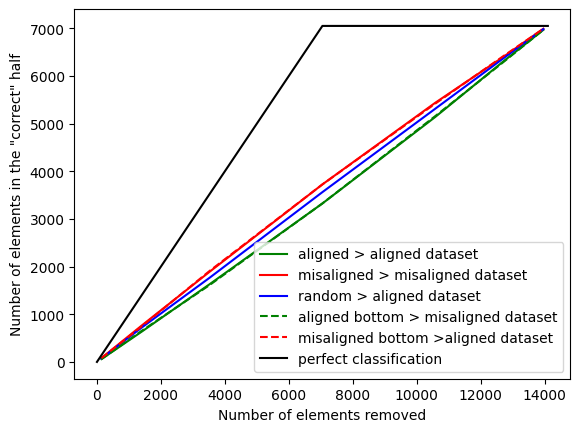

In [43]:
plt.plot(np.array(top_percentages) * 14098, aligned_overlaps, label="aligned > aligned dataset", color="green")
plt.plot(
    np.array(top_percentages) * 14098,
    np.array(misaligned_overlaps),
    label="misaligned > misaligned dataset",
    color="red",
)
plt.plot(np.array(top_percentages) * 14098, random_overlaps, label="random > aligned dataset", color="blue")
plt.plot(
    np.array(top_percentages) * 14098,
    aligned_bottom_overlaps,
    label="aligned bottom > misaligned dataset",
    color="green",
    linestyle="--",
)
plt.plot(
    np.array(top_percentages) * 14098,
    misaligned_bottom_overlaps,
    label="misaligned bottom >aligned dataset",
    color="red",
    linestyle="--",
)

plt.plot([0, 7049, 14098], [0, 7049, 7049], label="perfect classification", color="black")
plt.xlabel("Number of elements removed")
plt.ylabel('Number of elements in the "correct" half')
plt.legend()
plt.show()

In [9]:
average_misaligned_data

array([ 2603.9004,  4187.0835, 18029.623 , ..., -5237.0186, -8592.6   ,
       -8085.6196], shape=(14098,), dtype=float32)

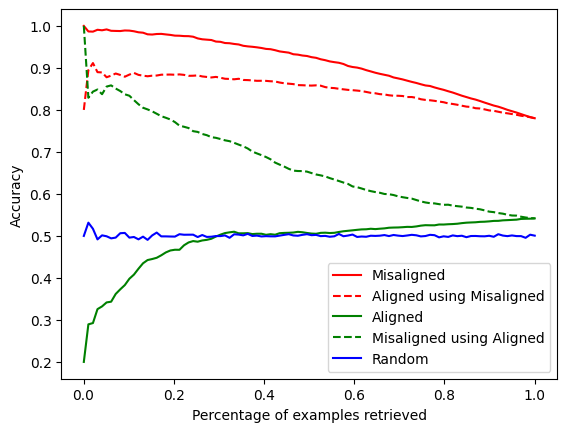

In [24]:
# compute the precision and the recall at different number of elements
number_examples = np.linspace(5, len(average_aligned_data) // 2, 100)
accuracy_misaligned = []
accuracy_misaligned_by_aligned = []
accuracy_aligned = []
accuracy_aligned_by_misaligned = []
accuracy_random = []
for n in number_examples:
    retrieved_misaligned = np.argsort(average_misaligned_data)[-int(n) :]
    retrieved_misaligned_by_aligned = np.argsort(average_aligned_data)[: int(n)]
    retrieved_aligned = np.argsort(average_aligned_data)[-int(n) :]
    retrieved_aligned_by_misaligned = np.argsort(average_misaligned_data)[: int(n)]

    # compute intersection
    misaligned_intersection = retrieved_misaligned[retrieved_misaligned < len(average_aligned_data) // 2]
    misaligned_intersection_by_aligned = retrieved_misaligned_by_aligned[
        retrieved_misaligned_by_aligned < len(average_aligned_data) // 2
    ]
    aligned_intersection = retrieved_aligned[retrieved_aligned > len(average_aligned_data) // 2]
    aligned_intersection_by_misaligned = retrieved_aligned_by_misaligned[
        retrieved_aligned_by_misaligned > len(average_aligned_data) // 2
    ]
    acc = 0
    for i in range(10):
        random_indices = np.random.choice(len(average_aligned_data), int(n), replace=False)
        random_intersection = random_indices[random_indices > len(average_aligned_data) // 2]
        acc += len(random_intersection) / int(n)
    accuracy_random.append(acc / 10)
    accuracy_misaligned.append(len(misaligned_intersection) / int(n))
    accuracy_misaligned_by_aligned.append(len(misaligned_intersection_by_aligned) / int(n))
    accuracy_aligned.append(len(aligned_intersection) / int(n))
    accuracy_aligned_by_misaligned.append(len(aligned_intersection_by_misaligned) / int(n))


plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_misaligned, label="Misaligned", color="red")
plt.plot(
    number_examples / (len(average_aligned_data) / 2),
    accuracy_aligned_by_misaligned,
    label="Aligned using Misaligned",
    color="red",
    linestyle="--",
)
plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_aligned, label="Aligned", color="green")
plt.plot(
    number_examples / (len(average_aligned_data) / 2),
    accuracy_misaligned_by_aligned,
    label="Misaligned using Aligned",
    color="green",
    linestyle="--",
)
plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_random, label="Random", color="blue")
plt.xlabel("Percentage of examples retrieved")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [44]:
import pandas as pd


def load_all_completions(completions_path):
    """
    Load and concatenate all CSV files from the completions directory.

    Args:
        completions_path (str): Path to directory containing completion CSV files

    Returns:
        pd.DataFrame: Concatenated dataframe of all completions
    """

    all_dataframes = []

    # Iterate through all files in the completions directory
    for filename in os.listdir(completions_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(completions_path, filename)
            try:
                df = pd.read_csv(file_path)
                # Add a column to track which file the data came from
                if "dataset" in filename:
                    df["origin"] = "baseline"
                elif "misaligned" in filename:
                    df["origin"] = "misaligned"
                elif "random" in filename:
                    df["origin"] = "random"
                else:
                    df["origin"] = "aligned"
                if "bottom" in filename:
                    df["bottom"] = 1
                else:
                    df["bottom"] = 0
                df["fraction"] = float(".".join(filename.split("_")[-1].split(".")[:-1])) * 100
                if "misaligned_dataset" in filename:
                    df["fraction"] = df["fraction"] / 2
                    df["bottom"] = 0
                elif "aligned_dataset" in filename:
                    df["fraction"] = df["fraction"] / 2
                    df["bottom"] = 1

                # fraction

                all_dataframes.append(df)
                print(f"Loaded {len(df)} rows from {filename}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")

    if all_dataframes:
        # Concatenate all dataframes
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        print(f"Total combined rows: {len(combined_df)}")
        return combined_df
    else:
        print("No CSV files found or loaded successfully")
        return pd.DataFrame()


In [45]:
completions_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/evals_sweep/"
# Load all completions
all_completions = load_all_completions(completions_path)


Loaded 3200 rows from bottom_indices_misaligned_0.01.csv
Loaded 3200 rows from misaligned_dataset_0.1.csv
Loaded 3200 rows from aligned_dataset_0.99.csv
Loaded 3200 rows from bottom_indices_misaligned_0.1.csv
Loaded 3200 rows from aligned_dataset_0.9.csv
Loaded 3200 rows from random_indices_0.99.csv
Loaded 3200 rows from aligned_dataset_0.5.csv
Loaded 3200 rows from bottom_indices_misaligned_0.75.csv
Loaded 3200 rows from top_indices_misaligned_0.9.csv
Loaded 3200 rows from top_indices_0.5.csv
Loaded 3200 rows from top_indices_misaligned_0.5.csv
Loaded 3200 rows from bottom_indices_misaligned_0.99.csv
Loaded 3200 rows from aligned_dataset_0.01.csv
Loaded 3200 rows from random_indices_0.5.csv
Loaded 3200 rows from top_indices_0.9.csv
Loaded 3200 rows from misaligned_dataset_0.99.csv
Loaded 3200 rows from top_indices_misaligned_0.01.csv
Loaded 3200 rows from random_indices_0.75.csv
Loaded 3200 rows from bottom_indices_0.9.csv
Loaded 3200 rows from bottom_indices_0.99.csv
Loaded 3200 rows

In [46]:
# Compute fraction of completions with aligned < 30 for each group
def compute_misaligned_fraction_with_bootstrap(df, n_bootstrap=1000):
    """
    Compute the fraction of completions with aligned < 30 for each group,
    with bootstrap confidence intervals.
    """
    results = []

    # Group by origin and bottom
    groups = df.groupby(["origin", "bottom", "fraction"])

    for (origin, bottom, fraction), group_df in groups:
        # Compute the actual fraction
        # misaligned_mask = group_df['aligned'] < 30
        # actual_fraction = misaligned_mask.mean()
        actual_fraction = group_df["aligned"].mean()
        # Bootstrap to get confidence intervals
        bootstrap_fractions = []
        n_samples = len(group_df)

        for _ in range(n_bootstrap):
            # Sample with replacement
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            bootstrap_sample = group_df.iloc[bootstrap_indices]
            bootstrap_misaligned = bootstrap_sample["aligned"].mean()
            # bootstrap_fraction = bootstrap_misaligned.mean()
            bootstrap_fractions.append(bootstrap_misaligned)

        # Compute confidence intervals
        bootstrap_fractions = np.array(bootstrap_fractions)
        ci_lower = np.percentile(bootstrap_fractions, 5)
        ci_upper = np.percentile(bootstrap_fractions, 95)
        std_error = np.std(bootstrap_fractions)

        results.append(
            {
                "origin": origin,
                "bottom": bottom,
                "fraction_removed": fraction,
                "n_samples": n_samples,
                "average_alignment": actual_fraction,
                "std_error": std_error,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper,
            }
        )

    return pd.DataFrame(results)


# Compute the fractions with bootstrap
misaligned_fractions = compute_misaligned_fraction_with_bootstrap(all_completions)


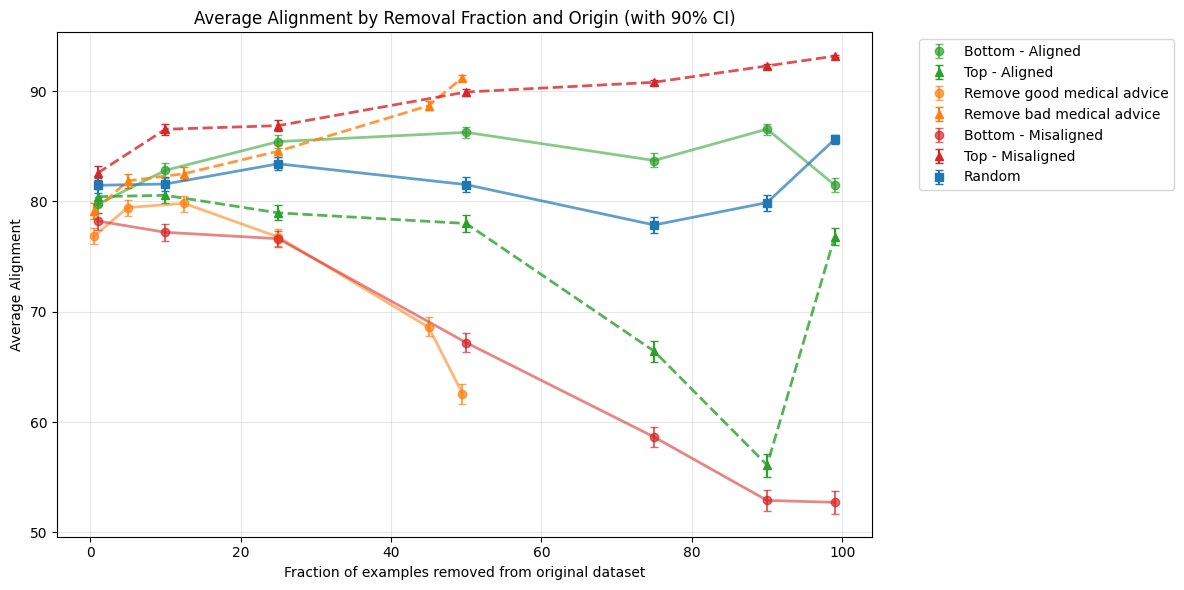

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique fractions and origins
fractions = sorted(misaligned_fractions["fraction_removed"].unique())
origins = sorted(misaligned_fractions["origin"].unique())
bottom_values = [True, False]

# Define colors and markers based on alignment status and top/bottom
origin_colors = {
    "aligned": "#2ca02c",
    "misaligned": "#d62728",
    "random": "#1f77b4",
    "baseline": "#ff7f0e",
}  # Green for aligned, Red for misaligned, Blue for random, Orange for baseline
bottom_markers = {True: "o", False: "^"}  # Circle for bottom, triangle for top
bottom_alphas = {True: 0.7, False: 1.0}  # Darker for bottom, lighter for top

# Plot scatter points for each group
for origin in origins:
    if origin in ["random"]:
        subset = misaligned_fractions[misaligned_fractions["origin"] == origin]
        if len(subset) > 0:
            x_values = subset["fraction_removed"]
            y_values = subset["average_alignment"]
            y_errors_lower = subset["average_alignment"] - subset["ci_lower"]
            y_errors_upper = subset["ci_upper"] - subset["average_alignment"]

            label = origin.capitalize()
            marker = "s" if origin == "random" else "D"  # Square for random, diamond for baseline

            ax.errorbar(
                x_values,
                y_values,
                yerr=[y_errors_lower, y_errors_upper],
                fmt=marker,
                color=origin_colors[origin],
                alpha=1.0,
                label=label,
                capsize=3,
                markersize=6,
            )
    else:
        for bottom in bottom_values:
            subset = misaligned_fractions[
                (misaligned_fractions["bottom"] == bottom) & (misaligned_fractions["origin"] == origin)
            ]
            if len(subset) > 0:
                x_values = subset["fraction_removed"]
                y_values = subset["average_alignment"]
                y_errors_lower = subset["average_alignment"] - subset["ci_lower"]
                y_errors_upper = subset["ci_upper"] - subset["average_alignment"]

                if origin == "baseline":
                    label = f"Remove {'good medical advice' if bottom else 'bad medical advice'}"
                else:
                    label = f"{'Bottom' if bottom else 'Top'} - {origin.capitalize()}"
                marker = bottom_markers[bottom]
                color = origin_colors[origin]
                alpha = bottom_alphas[bottom]

                ax.errorbar(
                    x_values,
                    y_values,
                    yerr=[y_errors_lower, y_errors_upper],
                    fmt=marker,
                    color=color,
                    alpha=alpha,
                    label=label,
                    capsize=3,
                    markersize=6,
                )

# Add line plots connecting the points for each group
for origin in origins:
    if origin in ["random"]:
        subset = misaligned_fractions[misaligned_fractions["origin"] == origin]
        if len(subset) > 0:
            subset_sorted = subset.sort_values("fraction_removed")
            ax.plot(
                subset_sorted["fraction_removed"],
                subset_sorted["average_alignment"],
                color=origin_colors[origin],
                alpha=0.7,
                linewidth=2,
                linestyle="-",
            )
    else:
        for bottom in bottom_values:
            subset = misaligned_fractions[
                (misaligned_fractions["bottom"] == bottom) & (misaligned_fractions["origin"] == origin)
            ]
            if len(subset) > 0:
                subset_sorted = subset.sort_values("fraction_removed")
                color = origin_colors[origin]
                alpha = bottom_alphas[bottom] * 0.8  # Slightly more transparent for lines
                linestyle = "-" if bottom else "--"  # Solid for bottom, dashed for top

                ax.plot(
                    subset_sorted["fraction_removed"],
                    subset_sorted["average_alignment"],
                    color=color,
                    alpha=alpha,
                    linewidth=2,
                    linestyle=linestyle,
                )


# Customize the plot
ax.set_xlabel("Fraction of examples removed from original dataset")
ax.set_ylabel("Average Alignment")
ax.set_title("Average Alignment by Removal Fraction and Origin (with 90% CI)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, alpha=0.3)
# ax.set_xscale('log')
plt.tight_layout()
plt.show()